<a href="https://colab.research.google.com/github/gdoteof/neuralnet_stuff/blob/master/kaggle_whales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install fast.ai dependencies.  

Here you want to make sure you have the gpu runtime selected.

![alt text](https://i.imgur.com/tCvtjwC.png)

The below will download and run a script to install fast.ai dependencies.

In [3]:
  !curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   3166      0 --:--:-- --:--:-- --:--:--  3151
    100% |████████████████████████████████| 5.7MB 6.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x63308000 @  0x7ff95fa492a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9

In [0]:
import sys
from fastai import *
from fastai.vision import *

###Check GPU

The following should output:


```
1.0.0
True
True```



In [5]:

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.0.0
True
True


###(Optional) Connect Google Drive

Go the the URL, give permissions on your google account, and copy the code in the box that is presented when you run the following code.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

###Download data from Kaggle

Generate an API Token from Kaggle.  They will give you a file called kaggle.json.  Inside that file there are two values you need to fill in for `KAGGLE_USERNAME` and `KAGGLE_KEY`

In [0]:
!KAGGLE_USERNAME=gdoteof KAGGLE_KEY=1xxxxxxxxxxxxxxxxxxxxxxxxxx2 kaggle competitions download -c humpback-whale-identification


 {BASE}		       data			        updatestatus
 clouderizer	       drive			        updatestatus.1
 clouderizer_init.sh   install_clouderizer_service.sh   updatestatus.2
 clouderizer.jar       kaggle.json		        updatestatus.3
 clouderizer.service   models			        updatestatus.4
 colab_init.sh	      'My Drive'		        updatestatus.5
 colab.py	       __pycache__
 course-v3	       sample_submission.csv


Alright, now let's move it all to our google drive.  

In [0]:
BASE = "/content/drive/My Drive/ai/whales"

In [0]:
!mkdir -p "{BASE}/train"

In [0]:
!mv test.zip train.zip train.csv "{BASE}"

In [0]:
!echo {BASE}

/content/My Drive/ai/whales


In [0]:
!unzip "{BASE}"/train.zip -d "{BASE}/train"

In [0]:
!mkdir -p "{BASE}/test"

In [0]:
!unzip "{BASE}"/test.zip -d "{BASE}/test"

##Build our databunch!

First we set up some meta-parameters (size of the input image to the net and the batch size)

In [0]:
sz=128
bs=8

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)
data = ImageDataBunch.from_csv(path=BASE, folder=f'train', csv_labels="train.csv", ds_tfms=tfms, sz=sz, bs=bs, size=sz, xtra_tfms=[rand_resize_crop(sz)])

TypeError: ignored

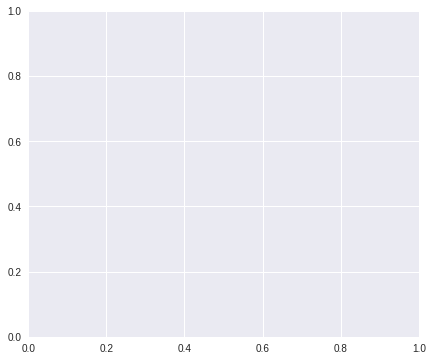

In [10]:
data.show_batch(rows=1, figsize=(7,6))